In [5]:
import pyabc
import scipy
import numpy as np
from pyabc.visualization import plot_kde_matrix_highlevel,plot_kde_matrix2,plot_kde_matrix_for_paper
from datetime import datetime
import pandas as pd
from arviz import hdi
from pyabc.visualization import plot_kde_matrix_highlevel, plot_kde_matrix
import numpy as np
import matplotlib.pyplot as plt

path = '../../results'
output_path = '../../figures'

f = 'basic-prior'

### You can jump [loading section](#loading) if you want only to plot figure and the data is already persisted

In [6]:
import sys  
sys.path.insert(0, '../models')
from singleLocusModel import SingleLocusModel
model = SingleLocusModel(k=1, stopon=3000, fixation=0.95)
N = 6*10**6

In [7]:
def sample_from_kde(file_name, size=50_000, t=None):
    history = pyabc.History("sqlite:///{0}/{1}/{1}.db".format(path, file_name))
    samples, weights = history.get_distribution(m=0, t=t)
    kde = scipy.stats.gaussian_kde(samples.T.values.tolist(),weights=weights)
    kdesamples = kde.resample(2*size).T
    kdesamples = pd.DataFrame(data=kdesamples,columns=['mutation rate', 'trisomy rate', '2n+1 fitness', '2n+1* fitness', '2n* fitness'])
    order_criteria = (kdesamples['2n+1 fitness'] < kdesamples['2n+1* fitness']) & (kdesamples['2n+1* fitness'] < kdesamples['2n* fitness'])
    kdesamples = kdesamples[(kdesamples['mutation rate']>1e-9) & (kdesamples['mutation rate']<1e-5) &
              (kdesamples['trisomy rate']>1e-6) & (kdesamples['mutation rate']<1e-2) & order_criteria][:size]

    return kdesamples


In [8]:
samples = sample_from_kde(f)

In [9]:
%%time
reps = 10000
# params = [[p[0],p[1],p[1],*p[2:]] for p in samples.sample(10).values]
model = SingleLocusModel(k=1, stopon=3000, fixation=0.999)
ps = []
grades = []
params = []
i=0
while i<20:
    n = samples.sample(1).values[0]
    n = [n[0],n[1],n[1],*n[2:]]

    times, p = model.run_simulations(N, *n, repetitions=reps, seed=111) #TODO 10,000
    grade = model.grade_function((times,p))
    if grade<-0.0002:
        i+=1
        grades.append(grade)
        ps.append(p)
        params.append(n)
        print(grade)

-0.256736333299875
-0.29900209874999994
-0.2225542323180002
-0.42445031557284774
-0.8206516852840928
-0.8723699846873089
-0.7188625954385407
-0.772862637421875
-0.0035951429146877656
-0.003994003997999984
-0.11543627079807672
-0.7234234998025728
-0.5457363504798749
-0.7056381467253727
-0.7860614437762048
-0.07574787031987484
-0.8493529514385889
-0.05137927346401583
-0.8597402815561728
-0.4014555851798751
CPU times: user 3h 16min 5s, sys: 2min 36s, total: 3h 18min 41s
Wall time: 3h 31min 50s


In [115]:
# takes too much disk space
# np.savez_compressed('./outputs/dynamics',params=params, grades=grades, ps=ps)
# loaded = np.load('./outputs/dynamics.npz',allow_pickle=True)
# params, grades, ps = loaded['params'], loaded['grades'], loaded['ps']

In [13]:
%%time
import numpy as np
progresses_median = []
progresses_mean = []
for p in ps[:]:
    nparr = np.array(p)
    progresses_median.append(
    [[np.median(a) for a in nparr[:,0][:]],
    [np.median(a) for a in nparr[:,1][:]],
    [np.median(a) for a in nparr[:,2][:]],
    [np.median(a) for a in nparr[:,3][:]]])
    
    progresses_mean.append(
    [[a.mean() for a in nparr[:,0][:]],
    [a.mean() for a in nparr[:,1][:]],
    [a.mean() for a in nparr[:,2][:]],
    [a.mean() for a in nparr[:,3][:]]])

CPU times: user 3min 18s, sys: 2min 49s, total: 6min 8s
Wall time: 11min 55s


In [19]:
#uncomment if needed
np.savez('./outputs/dynamics-summary',progresses_median=progresses_median, progresses_mean=progresses_mean)

/Users/adsurbum/opt/miniconda3/envs/py371/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


<a id='loading'></a>

# Loading persisted
## uncomment the next cell if needed

In [133]:
# load = np.load('./outputs/dynamics-summary.npz', allow_pickle=True)
# progresses_median = load['progresses_median']
# progresses_mean = load['progresses_mean']

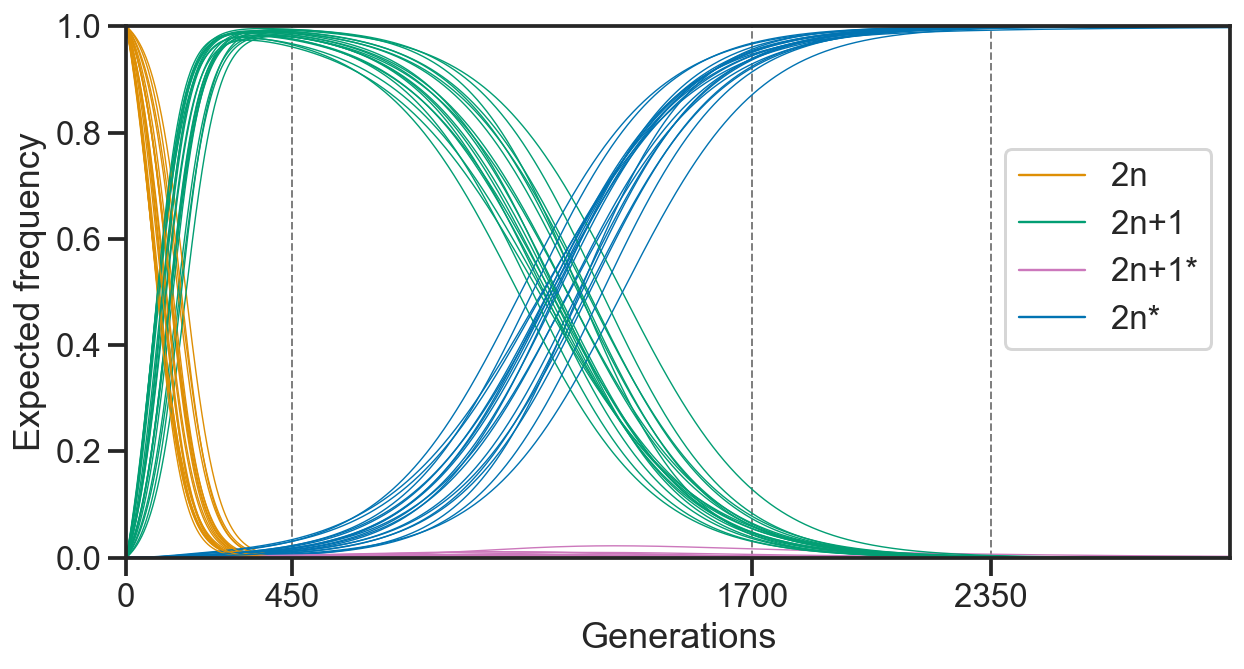

In [20]:
import seaborn as sns
sns.set(style="ticks",context='talk' ,rc={"lines.linewidth": 2.5, 'lines.markersize': 7})
blue,yellow,green,red,pink,brown,pink2,grey = sns.color_palette("colorblind", 8)

def plot_progress(progresses, state_names=['2n','2n+1','2n+1*','2n*'], colors=[yellow,green,pink,blue]):
    fig, ax = plt.subplots(figsize=(9, 5))

    #nparr[:,stateid][:,replicaid]

#     plt.fill_between([450, 1700], [0,0], [1,1] , alpha=0.2, color=red)
#     plt.fill_between([1701, 2350], [0,0], [1,1] , alpha=0.2, color=blue)
    plt.axvline(450,linestyle='--',linewidth=1, color='grey')
    plt.axvline(1700,linestyle='--',linewidth=1, color='grey')
    plt.axvline(2350,linestyle='--',linewidth=1, color='grey')

    first = True
    for p in progresses:
        ind = -1
        for n,c in zip(state_names, colors):
            ind+=1
            if first==True:
                plt.plot(range(min(len(p[0]),3000)), p[ind], label=n, color=c,linewidth=0.7)
            else:
                plt.plot(range(min(len(p[0]),3000)), p[ind], color=c, linewidth=0.7)
        first=False

    plt.xlabel('Generations')
    plt.ylabel('Expected frequency')
    
#     plt.xlim(10**-0.2,3000)
#     plt.ylim(10**-5,10**0.2)
#     plt.xscale('log')
#     plt.yscale('log')
    leg = plt.legend(loc='upper center', bbox_to_anchor=(0.89, 0.8))
    for line in leg.get_lines():
        line.set_linewidth(1.2)
        
    plt.xlim(0,3000)
    plt.ylim(0,1)
    ax.set_xticks([0,450,1700,2350])
    
plot_progress(progresses_mean[:20])
plt.tight_layout()
plt.gcf().savefig(f'{output_path}/dynamics.pdf', bbox_inches='tight', dpi=100)

# Here we will calculate 2n+1 fixation time

In [15]:
%%time
reps = 1000
# params = [[p[0],p[1],p[1],*p[2:]] for p in samples.sample(10).values]
model = SingleLocusModel(k=1, stopon=3000, fixation=0.999)
ps = []
grades = []
params = []
i=0
while i<20:
    n = samples.sample(1).values[0]
    if not np.all(n>0):
        continue
    n = [n[0],n[1],n[1],*n[2:]]

    times, p = model.run_simulations(N, *n, repetitions=reps, seed=111)
    grade = model.grade_function((times,p))
    if grade<-0.0002:
        i+=1
        grades.append(grade)
        ps.append(p)
        params.append(n)
        print(grade)

-0.03161803980800004
-0.6561969351679999
-0.07763168000000009
-0.5038233275180001
-0.776823748638
-0.4847763454380001
-0.011625981743999796
-0.7688182335679999
-0.642100735488
-0.863061494078
-0.1716843890880002
-0.6200212193279999
-0.871529327328
-0.007975592703999945
-0.8713219987499999
-0.5380320788480001
-0.11835131695800005
-0.378041008128
-0.15418403247800017
-0.3111683915179999
CPU times: user 48min 42s, sys: 1min 30s, total: 50min 12s
Wall time: 59min 10s


In [16]:
two_plus_one_fixations = [int(np.mean([(np.array(p)[:,1][:450,replica_id]>0.95).argmax() for replica_id in range(reps)])) for p in ps]
two_plus_one_fixations

[238,
 260,
 263,
 250,
 248,
 223,
 278,
 222,
 213,
 266,
 275,
 203,
 242,
 271,
 296,
 225,
 202,
 216,
 241,
 207]

In [18]:
np.mean(two_plus_one_fixations)

241.95

In [19]:
np.mean(two_plus_one_fixations)

247.15